# Pré-processamento MIAS – Notebook

**Contexto:** Este notebook realiza o pré-processamento das 322 mamografias do **mini-MIAS**, seguindo o pipeline descrito no artigo (silhueta → crop → normalização → (opcional) resize) e gera saídas prontas para as etapas de equalização.

## O que este notebook faz
- Lê todas as imagens `.pgm` na pasta `./MIAS` (ao lado deste notebook);
- Gera a **silhueta da mama** (equalização global + Otsu + morfologia);
- Realiza o **crop** para remover fundo/rótulos;
- Aplica **normalização robusta** por percentis (0.5–99.5 por padrão);
- (Opcional) **Redimensiona** para um tamanho fixo (ex.: 1024×1024);
- Salva imagens **pré-processadas** (PNG 8-bit) e **máscaras** (PNG 8-bit);
- Gera um **manifesto CSV** com metadados do seu arquivo `mias_derived_info.csv`;
- Mostra o **balanceamento por classe** (Normal/Benign/Malignant) e algumas amostras de saída.

> Coloque este notebook **na mesma pasta** onde estão as pastas/arquivos:
> - `./MIAS/` (com as 322 imagens)  
> - `./mias_derived_info.csv`  
> - Este notebook (`preprocess_mias.ipynb`).

In [1]:
# ==== Configuração de caminhos (relativos ao notebook) ====
from pathlib import Path

BASE_DIR = Path('.')
MIAS_DIR = BASE_DIR / 'MIAS'                     # pasta com as imagens .pgm
CSV_PATH = BASE_DIR / 'mias_derived_info.csv'    # metadados fornecidos
OUTPUT_DIR = BASE_DIR / 'outputs_preproc'        # para salvar resultados

# Parâmetros do pipeline
TARGET_SIZE = 1024   # use 0 para não redimensionar
NORM_LOW_PCT = 0.5
NORM_HIGH_PCT = 99.5

print('MIAS_DIR =', MIAS_DIR.resolve())
print('CSV_PATH =', CSV_PATH.resolve())
print('OUTPUT_DIR =', OUTPUT_DIR.resolve())

MIAS_DIR = C:\Users\jhter\OneDrive - cefet-rj.br\Processamento-Imagem\Trabalho-1\MIAS
CSV_PATH = C:\Users\jhter\OneDrive - cefet-rj.br\Processamento-Imagem\Trabalho-1\mias_derived_info.csv
OUTPUT_DIR = C:\Users\jhter\OneDrive - cefet-rj.br\Processamento-Imagem\Trabalho-1\outputs_preproc


In [8]:
# ==== Imports e utilidades ====
import os, re, glob
import numpy as np
import pandas as pd
import cv2
from skimage import io, exposure, filters, morphology, measure, util
import matplotlib.pyplot as plt
import scipy.ndimage as ndi

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def img_to_float01(img):
    img = img.astype(np.float32)
    if img.max() > 1.0:
        img /= 255.0
    return np.clip(img, 0.0, 1.0)

def save_uint8(image_f32, out_path: Path):
    u8 = np.clip(image_f32, 0, 1)
    u8 = (u8 * 255.0 + 0.5).astype(np.uint8)
    cv2.imwrite(str(out_path), u8)

def robust_normalize(img, low_pct=0.5, high_pct=99.5):
    lo, hi = np.percentile(img, (low_pct, high_pct))
    if hi <= lo:
        return np.clip(img, 0, 1)
    return np.clip((img - lo) / (hi - lo), 0, 1)

def read_image(path):
    img = io.imread(path)
    if img.ndim == 3:  # PNG RGB -> cinza
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img_to_float01(img)


def breast_silhouette(img):
    """Silhueta da mama: equalização global -> Otsu -> maior componente -> morfologia."""
    eq = exposure.equalize_hist(img)
    thr = filters.threshold_otsu(eq)
    mask = (eq > thr).astype(np.uint8)

    labels = measure.label(mask, connectivity=2)
    if labels.max() == 0:
        return mask

    binc = np.bincount(labels.ravel())
    binc[0] = 0  # ignora fundo
    largest = binc.argmax()
    mask = (labels == largest).astype(np.uint8)

    mask = morphology.binary_closing(mask, morphology.disk(5)).astype(np.uint8)
    mask = ndi.binary_fill_holes(mask).astype(np.uint8)
    return mask

def crop_to_breast(img, mask):
    ys, xs = np.where(mask > 0)
    if len(xs) == 0:
        return img, mask, (0, img.shape[0], 0, img.shape[1])
    y0, y1 = ys.min(), ys.max()
    x0, x1 = xs.min(), xs.max()
    cropped_img = img[y0:y1+1, x0:x1+1] * mask[y0:y1+1, x0:x1+1]
    cropped_mask = mask[y0:y1+1, x0:x1+1]
    return cropped_img, cropped_mask, (y0, y1+1, x0, x1+1)

def resize_if_needed(img, mask, target_size:int):
    if not target_size or target_size <= 0:
        return img, mask
    return (cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA),
            cv2.resize(mask, (target_size, target_size), interpolation=cv2.INTER_NEAREST))

def extract_refnum(filename:str):
    base = os.path.basename(filename).lower()
    m = re.search(r"(mdb\d{3})", base)
    return m.group(1) if m else os.path.splitext(base)[0]


In [9]:
# ==== Execução do pré-processamento em lote (PNG) ====
from datetime import datetime
from tqdm import tqdm

assert MIAS_DIR.is_dir(), f"Pasta MIAS não encontrada: {MIAS_DIR}"
ensure_dir(OUTPUT_DIR)
out_img_dir = OUTPUT_DIR / 'images'
out_mask_dir = OUTPUT_DIR / 'masks'
ensure_dir(out_img_dir); ensure_dir(out_mask_dir)

# carrega metadados (opcional)
meta = None
if CSV_PATH.is_file():
    meta = pd.read_csv(CSV_PATH)
    meta['REFNUM'] = meta['REFNUM'].astype(str).str.lower()
    meta = meta.set_index('REFNUM')
    print('Metadados carregados:', meta.shape)
else:
    print('Arquivo de metadados não encontrado, seguindo sem metadados…')

# PROCURA PNG (maiusc/minusc)
imgs = sorted(list(MIAS_DIR.glob('*.png')) + list(MIAS_DIR.glob('*.PNG')))
print(f"Imagens encontradas: {len(imgs)}")
assert len(imgs) > 0, 'Nenhuma .png encontrada em ./MIAS'

logs = []
for p in tqdm(imgs, desc='Pré-processando (PNG)'):
    # leitor genérico que funciona com PNG; se sua função se chamar read_pgm, troque por read_image
    img = read_image(p)
    mask = breast_silhouette(img)
    img_c, mask_c, (y0,y1,x0,x1) = crop_to_breast(img, mask)
    img_n = robust_normalize(img_c, NORM_LOW_PCT, NORM_HIGH_PCT)
    img_r, mask_r = resize_if_needed(img_n, mask_c, TARGET_SIZE)

    basename = p.stem
    out_img = out_img_dir / f"{basename}_preproc.png"
    out_msk = out_mask_dir / f"{basename}_mask.png"
    save_uint8(img_r, out_img)
    save_uint8(mask_r.astype(np.float32), out_msk)

    info = {
        'timestamp': datetime.now().isoformat(timespec='seconds'),
        'input_path': str(p),
        'output_img': str(out_img),
        'output_mask': str(out_msk),
        'crop_y0': y0, 'crop_y1': y1, 'crop_x0': x0, 'crop_x1': x1,
        'height': img_r.shape[0], 'width': img_r.shape[1],
        'REFNUM': extract_refnum(str(p)),
    }
    if meta is not None and info['REFNUM'] in meta.index:
        row = meta.loc[info['REFNUM']]
        for col in ['BG','CLASS','SEVERITY','X','Y','RADIUS','DENSITY','BI-RADS','CLASS_FULL','CLASS_GROUP']:
            info[col] = row.get(col, np.nan) if hasattr(row, 'get') else (row[col] if col in row.index else np.nan)
    logs.append(info)

df_log = pd.DataFrame(logs)
manifest_path = OUTPUT_DIR / 'preprocess_manifest.csv'
df_log.to_csv(manifest_path, index=False)
print('Manifest salvo em:', manifest_path)
if 'SEVERITY' in df_log.columns:
    print('\nBalanceamento por SEVERITY:')
    print(df_log['SEVERITY'].value_counts(dropna=False))


Metadados carregados: (330, 10)
Imagens encontradas: 644


Pré-processando (PNG): 100%|██████████| 644/644 [01:46<00:00,  6.02it/s]


Manifest salvo em: outputs_preproc\preprocess_manifest.csv

Balanceamento por SEVERITY:
SEVERITY
Normal                                                                                     414
Benign                                                                                     118
Malignant                                                                                   98
REFNUM
mdb005    Benign
mdb005    Benign
Name: SEVERITY, dtype: object                       1
REFNUM
mdb005    Benign
mdb005    Benign
Name: SEVERITY, dtype: object                       1
REFNUM
mdb132    Benign
mdb132    Benign
Name: SEVERITY, dtype: object                       1
REFNUM
mdb132    Benign
mdb132    Benign
Name: SEVERITY, dtype: object                       1
REFNUM
mdb144       Benign
mdb144    Malignant
Name: SEVERITY, dtype: object                 1
REFNUM
mdb144       Benign
mdb144    Malignant
Name: SEVERITY, dtype: object                 1
REFNUM
mdb223    Benign
mdb223    Benign
Name: S

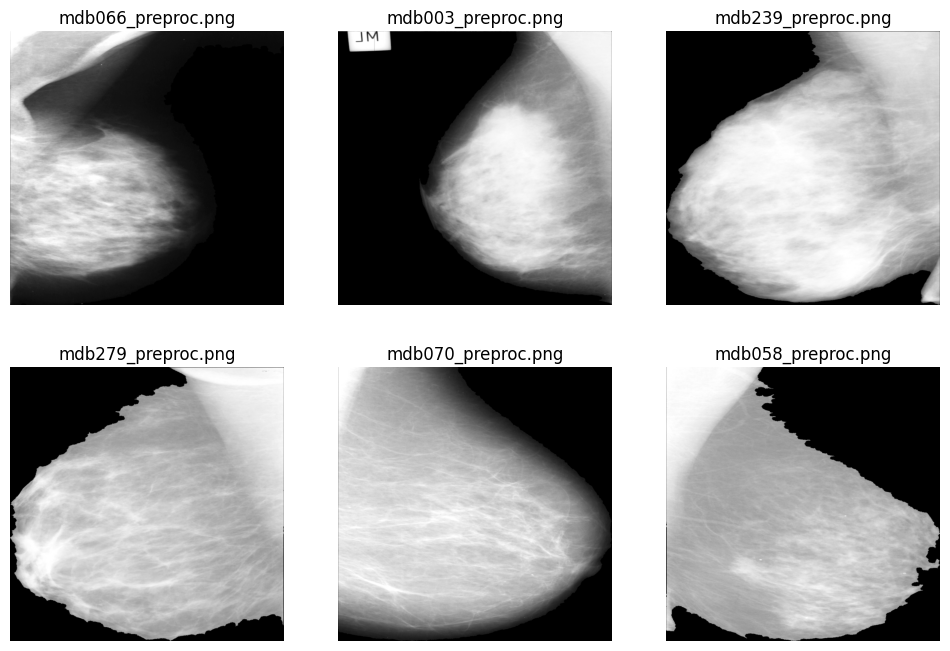

In [10]:
# ==== Visualização rápida de algumas saídas ====
import random
imgs = sorted(list((OUTPUT_DIR / 'images').glob('*_preproc.png')))
if len(imgs) == 0:
    print('Nenhuma imagem pré-processada encontrada ainda. Execute a célula anterior.')
else:
    samples = random.sample(imgs, k=min(6, len(imgs)))
    n = len(samples)
    cols = 3
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(12, 4*rows))
    for i, sp in enumerate(samples, 1):
        img = cv2.imread(str(sp), cv2.IMREAD_GRAYSCALE)
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='gray')
        plt.title(sp.name)
        plt.axis('off')
    plt.show()

## Próximos passos
1. Validar visualmente as imagens e máscaras em `./outputs_preproc/images` e `./outputs_preproc/masks`.
2. Avançar para a etapa de **equalização** (HIW/CLAHE) com os parâmetros do artigo (tests 1–6).
3. (Opcional) Extrair patches 32×32 e balancear por classe para treinar a CNN.